# Football Prediction
---

Description of task.

### Imports and Dependencies
---

Bing bong.

In [58]:
import numpy as np
import pandas as pd
import gpflow as gpf
import tensorflow as tf
import matplotlib.pyplot as plt

from gpflow.kernels import Matern52, SquaredExponential
from gpflow.likelihoods import Poisson
from gpflow.models import SVGP
from gpflow.optimizers import Scipy

from src.plotting import plot_feature_distributions

### Load Dataset
---

Bing bong.

In [13]:
data = pd.read_csv("data/dataset.csv", index_col=0)
data.head()

,team_event_id,x,y,ht_home,ht_away,ft_home,ft_away
0,2512081,3.304210,-2.097264,0.0,1.0,0.0,3.0
1,2512082,2.787051,-1.014194,0.0,0.0,1.0,0.0
2,2512083,2.443578,1.181806,0.0,1.0,0.0,2.0
3,2512084,2.254428,0.206387,0.0,0.0,0.0,2.0
4,2512088,3.168832,1.591534,2.0,0.0,2.0,1.0


### Visualise Dataset and Remove Outliers
---

First, let's count the number of NaN values in the dataset and see what proprtion of the total dataset they represent.

In [4]:
num_data = data.shape[0]
num_nans = data.isnull().values.sum()
print(f"NaN proportion: {num_nans / num_data :.5f}")

NaN proportion: 0.00023


Since the NaN values represent a small subset of the total datapoints, let's just drop them from the dataset.

In [5]:
data = data.dropna()

Now let's impose some constraints on the possible values of goals scored. Goals must be non-negative, and while the theoretical maximum number of goals possible to score in a 90 minute match is probably somewhere in the hundreds or thousands, the practical limit is much lower. A quick Google search tells us that the highest-scoring Premier League match of all-time was an 11-goal matchup between Portsmouth and Reading in 2007 with a final score of 7-4. We don't know if the dataset we have is for professional or amateur matches, but it's likely that there is higher variance in the final scores of amateur matches, so let's cap our goals scored at 15.

In [6]:
data = data.drop(data[(data["ft_home"] < 0) | (data["ft_home"] > 15)].index)
data = data.drop(data[(data["ft_away"] < 0) | (data["ft_away"] > 15)].index)

It's difficult to impose constraints on our mystery features x and y since we don't know what they are. So for now, let's just plot some histograms of the continuous features x and y and bar charts of our count-valued targets ft_home and ft_away.

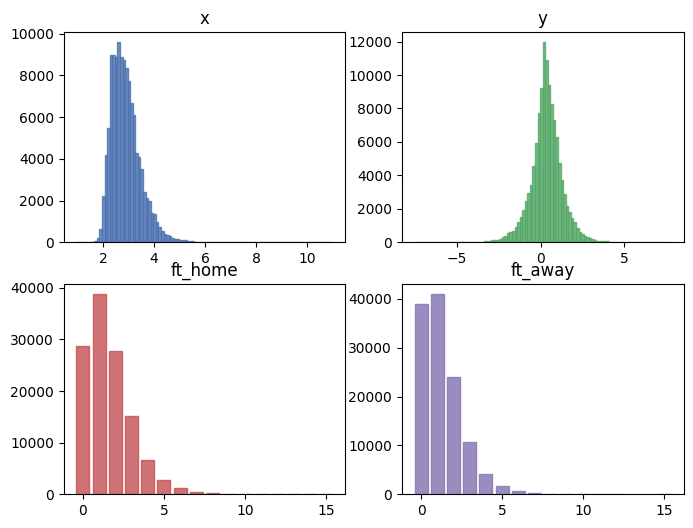

In [7]:
fig = plot_feature_distributions(data, figsize=(8, 6))
plt.show()

Overall, the distributions above look pretty sensible and there are no glaring outliers :)

### Design Decision -- Single or Multi-Output Regression
---

One key modelling decision we need to make is whether to model the home and away scores separately, or create a joint model. Multi-output regression is more complicated to implement than single-output regression, but if there is strong covariance between the home and away scores, it is important to capture this in our model. We can do a quick check by computing the Pearson correlation coefficient between home and away scores.

In [9]:
corr = np.corrcoef(data["ft_home"], data["ft_away"])
print(f"Correlation between home and away scores: {corr[0][1]:.5f}")

Correlation between home and away scores: -0.09048


This is a very low correlation coefficient. The fact that home and away scores are weakly correlated makes sense intuitively, as there is no obvious reason why if one team scores many goals the other should be more or less likely to also score many goals. As such, we will go ahead and model the home and away scores separately.

### Partition Training and Test Data
---

The last thing to do before setting up our model(s) is to split our dataset into a training and test set. Let's shuffle the dataset and do a 70/30 train/test split.

In [55]:
# 70/30 random split
train_proportion = 0.7
train_mask = np.random.rand(len(data)) < train_proportion
data_train = data[train_mask]
data_test = data[~train_mask]

# Extract training features + labels
features_train = data_train[["x", "y"]].values
home_score_train = data_train[["ft_home"]].values
away_score_train = data_train[["ft_away"]].values

# Extract test features and labels
features_test = data_test[["x", "y"]].values
home_score_test = data_test[["ft_home"]].values
away_score_test = data_test[["ft_away"]].values

### Create Home Score Model
---

Bing bong.

In [56]:
M = 50
N = features_train.shape[0]
D = features_train.shape[1]

likelihood = Poisson()

kernel = Matern52(D)

inducing_variables = features_train[:M, :].copy()

home_score_model = SVGP(
    kernel=kernel,
    likelihood=likelihood,
    inducing_variable=inducing_variables,
    num_data=N,
)


In [62]:
optimizer = Scipy()
loss = home_score_model.training_loss_closure((features_train, home_score_train))
params = home_score_model.trainable_variables
optimizer.minimize(loss, params)


# gpf.utilities.print_summary(home_score_model, "notebook")


# minibatch_size = 100
# elbo = tf.function(home_score_model.elbo)

# # TensorFlow re-traces & compiles a `tf.function`-wrapped method at *every* call if the arguments are numpy arrays instead of tf.Tensors. Hence:
# tensor_data = tuple(map(tf.convert_to_tensor, (features_train, home_score_train)))
# elbo(tensor_data)  # run it once to trace & compile

# # train_dataset = tf.data.Dataset.from_tensor_slices((X, Y)).repeat().shuffle(N)

# # train_iter = iter(train_dataset.batch(minibatch_size))

# # ground_truth = elbo(tensor_data).numpy()

  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: nan
        x: [       nan        nan ...        nan        nan]
      nit: 0
      jac: [       nan        nan ...        nan        nan]
     nfev: 22
     njev: 22
 hess_inv: <1427x1427 LbfgsInvHessProduct with dtype=float64>

### Plot Predictions
---

Bing bong.

The data:

- `team_event_id`: This is a unique identifier for a single football match
- `x` and `y`: Features we've collected about the football match
- `ht/ft_home/away`: These are the observed halftime (ht) and fulltime (ft) scores for the home and away teams respectively

The challenge:

We'd like you to use this dataset to build a model that can estimate the probabilities of fulltime scores of both teams using the mystery `x` and `y` features.  The type of model is completely up to you, but please try to justify your choices in jupyter markdown cells or code comments, and briefly discuss drawbacks of the model and improvements that could be made. Feel free to use any standard pip installable modelling package you are comfortable with.

The data may contain some outliers or mistakes so we recommend visualising the data to get a good understanding of what is going on :)